In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [4]:
stocks = pd.read_excel('Individual_stock_data.xlsx',sheet_name='stock prices', index_col = 0)

In [5]:
newdf = stocks.select_dtypes(include='object')
for column in newdf.columns:
    stocks = stocks.drop(column, axis = 1)

In [6]:
#Compute the returns of the stocks
values=stocks
stocks = stocks.pct_change()


In [7]:
#Remove the first week because it is the reference year
stocks = stocks.iloc[1:]
values=values.iloc[1:]

In [8]:
index = pd.read_excel('Individual_stock_data.xlsx',sheet_name='SP500',index_col = 0)

In [9]:
#Compute the returns
index = index.pct_change()
index = index.iloc[1:]

In [10]:
static_data = pd.read_excel('Individual_stock_data.xlsx',sheet_name='carbon footprint data')

In [12]:
#rename first column
static_data = static_data.rename(columns={'Unnamed: 0': 'StockNames'})
#Set index
static_data.set_index(['StockNames'], inplace=True)
#Set dataframe
static_data = static_data[['SECTOR','SECTOR_NAME','INTENSITY']]

for ind in newdf.columns:
    static_data = static_data.drop(ind, axis = 0)

In [13]:
def portfolio_return(weights,st):
    return(pd.DataFrame(((weights*st).transpose()).sum(),index = index.index))

In [14]:
from scipy.optimize import minimize
    
def mTE(stocks,indx):
    """
    Returns the weights of the portfolio that gives you the maximum sharpe ratio
    given the riskfree rate and expected returns and a covariance matrix
    """
    n = stocks.shape[1]
    T = stocks.shape[0]
    #init_guess = np.repeat(1/n, n)
    init_guess = np.repeat(0, n)
    init_guess[0]=1
    
    bounds = ((0.0, 1.0),) * n # an N-tuple of 2-tuples!
    # construct the constraints
    weights_sum_to_1 = {'type': 'eq',
                        'fun': lambda weights: np.sum(weights) - 1
    }
    def TE(weights, stocks, indx):
        """
        Returns the tracking error
        """
        r = portfolio_return(weights, stocks)
        diff = r.values - indx.values
        return ((diff)**2/T).sum()
    
    weights = minimize(TE, init_guess,
                       args=(stocks, indx), method='SLSQP',
                       options={'disp': False},
                       constraints=(weights_sum_to_1,),
                       bounds=bounds)
    return weights.x


In [15]:
w = mTE(stocks,index)

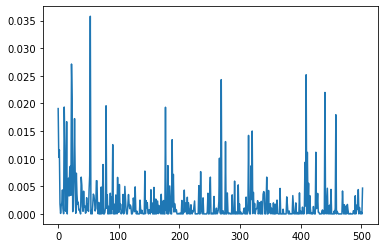

In [16]:
plt.plot(w)

In [17]:
index_CI = (w*static_data['INTENSITY']).sum()    # Intensité carbone de l'index SP500 (à utiliser dans les contraines)

# Strategy 1 : max ENC (dollar)

In [18]:
from scipy.optimize import minimize
    
def mENC(stocks):
    """
    Returns the weights of the portfolio that gives you the maximum sharpe ratio
    given the riskfree rate and expected returns and a covariance matrix
    """
    n = stocks.shape[1]
    T = stocks.shape[0]
    #init_guess = np.repeat(1/n, n)
    init_guess = np.zeros(n)
    init_guess[0] = 1
    bounds = ((0.0, 1.0),) * n # an N-tuple of 2-tuples!
    # construct the constraints
    weights_sum_to_1 = {'type': 'eq',
                        'fun': lambda weights: np.sum(weights) - 1
    }
    def ENC(weights, stocks):
        """
        Returns ENC
        """
        return -1/(((weights)**2).sum())
    weights = minimize(ENC, init_guess,
                       args=(stocks), method='SLSQP',
                       options={'disp': False},
                       constraints=(weights_sum_to_1,),
                       bounds=bounds)
    return weights.x

# Strategy 2 : min Tracking Error

In [19]:
from scipy.optimize import minimize

def portfolio_return(weights,st,indx):
    return(pd.DataFrame(((weights*st).transpose()).sum(),index = indx.index))

def mTE2(st,indx):
    """
    Returns the weights of the portfolio that gives you the maximum sharpe ratio
    given the riskfree rate and expected returns and a covariance matrix
    """
    n = st.shape[1]
    T = st.shape[0]
 
    init_guess = np.zeros(n)
    init_guess[0]=1

    bounds = ((0.0, 1.0),) * n # an N-tuple of 2-tuples!
    # construct the constraints
    weights_sum_to_1 = {'type': 'eq',
                        'fun': lambda weights: np.sum(weights) - 1
    }
    def TE2(weights, st, indx):
        """
        Returns the tracking error
        """
        r = portfolio_return(weights, st,indx)
        diff = r.values - indx.values
        return ((diff)**2/T).sum()
    
    weights = minimize(TE2, init_guess,
                       args=(st, indx), method='SLSQP',
                       options={'disp': False},
                       constraints=weights_sum_to_1,
                       bounds=bounds)
    return weights.x


# Strategy 3 : min variance

In [20]:
from scipy.optimize import minimize
    

def mVAR(stocks):
    """
    Returns the weights of the portfolio that gives you the maximum sharpe ratio
    given the riskfree rate and expected returns and a covariance matrix
    """
    n = stocks.shape[1]
    T = stocks.shape[0]
    init_guess = np.repeat(1/n, n)
    #init_guess = np.zeros(n)
    #init_guess[0]=0.5
    #init_guess[1]=0.5
    bounds = ((0.0, 1.0),) * n # an N-tuple of 2-tuples!
    # construct the constraints
    weights_sum_to_1 = {'type': 'eq',
                        'fun': lambda weights: np.sum(weights) - 1
    }
    def VAR(weights, stocks):
        """
        Returns the variance
        """
        return np.dot(weights,np.dot(stocks.cov(),weights))
        #return ((weights*Var)**2).sum()
    
    weights = minimize(VAR, init_guess,
                       args=(stocks), method='SLSQP',
                       options={'disp': False},
                       constraints=(weights_sum_to_1,),
                       bounds=bounds)
    return weights.x


# Strategy 4 : max ENCB (risks)

In [21]:
from scipy.optimize import minimize
    
def VAR(weights, stocks):
        """
        Returns the variance
        """
        return np.dot(weights,np.dot(stocks.cov(),weights))

def mENCB(stocks):
    """
    Returns the weights of the portfolio that gives you the maximum sharpe ratio
    given the riskfree rate and expected returns and a covariance matrix
    """
    n = stocks.shape[1]
    T = stocks.shape[0]
    #init_guess = np.repeat(1/n, n)
    init_guess = np.zeros(n)
    init_guess[0]=0.5
    init_guess[1]=0.5
    bounds = ((0.0, 1.0),) * n # an N-tuple of 2-tuples!
    # construct the constraints
    weights_sum_to_1 = {'type': 'eq',
                        'fun': lambda weights: np.sum(weights) - 1
    }
    def ENCB(weights, stocks):
        """
        Returns the variance
        """
        p=(weights*np.dot(stocks.cov(),weights))/VAR(weights, stocks)
        
        return -1/(p**2).sum()
    
    weights = minimize(ENCB, init_guess,
                       args=(stocks), method='SLSQP',
                       options={'disp': False},
                       constraints=(weights_sum_to_1,),
                       bounds=bounds)
    return weights.x


# Indicators (functions)

In [38]:
def Sharpe(weights,st):
    return np.dot(weights,st.mean(axis=0))/VAR(weights,st)    # Sharpe ratio with the risk free rate = 0

#Annualized volatility
def Annualized_vol(weights,st):
    return np.dot(weights,st.var(axis=0))*np.sqrt(52)  #Number of week in one year

#Expected returns
def E_returns(weights,st):
    return (1+np.dot(weights,st.mean(axis=0)))**(12)


# COMPUTATIONS 

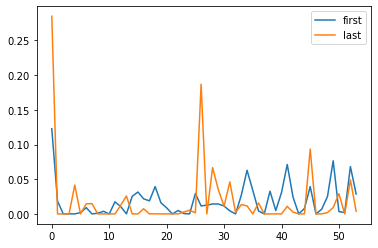

In [39]:
delta=round(104)                                 # 2 years
delta_3m=round(12)                               # 3 months
N=stocks.shape[0]                         # Time data available
Periods=round(N/delta_3m)                 # Number of 3 months periods

w_list=[]
expected_returns=[]
Sharpe_ratio=[]
Annualized_volatility=[]

start=round(0)
end=round(delta)
for j in range(Periods):
    stocks_period=stocks.iloc[start:end]          # 2 first years of data
    bool=~stocks_period.isna().any(axis=0)    # Remove company if missing data

    names=[]
    for p in range(stocks_period.shape[1]):
        if bool[p]==True:
            names.append(bool.index[p])

    stocks_period[names].head()

    # Get sectors names
    static_data_ps=static_data.loc[names]

    SECTORS=static_data_ps['SECTOR'].unique()
    ratio=np.zeros(len(SECTORS))
    selected=[]

    for k,i in enumerate(SECTORS) :
        ratio[k]=(static_data_ps.loc[static_data_ps['SECTOR']==i].SECTOR.count())/len(static_data_ps)   # Pourcentage of each sectors in SP500
        selected.append(static_data_ps.loc[static_data_ps['SECTOR']==i].sort_values(by=['INTENSITY'])[:int(ratio[k]*50)+1])    # Select the companies in each sector with the best carbon intensity, while respecting the ratio in SP500

    #Create a list with the stocks of the selected companies 
    m=0
    list=[]
    for i in range(11):
        list.append(selected[i])

    pos_scr=pd.concat(list).sort_values(by=['INTENSITY'])
    #Dataframe of the ~ 50 selected stocks
    stocks2=stocks_period[pos_scr.index]    #returns
    #values2=values[pos_scr.index]    # $ values of the stocks
    index2=index.iloc[start:end]

    w=mTE2(stocks2,index2)

    w_list.append(w)
    
    expected_returns.append(E_returns(w,stocks2))
    Sharpe_ratio.append(Sharpe(w,stocks2))
    Annualized_volatility.append(Annualized_vol(w,stocks2))

    start=start+delta_3m
    end=end+delta_3m

plt.plot(w_list[0],label='first')
plt.plot(w_list[-1],label='last')
plt.legend()
plt.show()




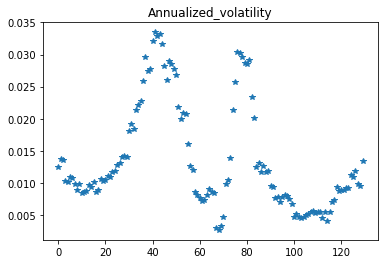

130
[1.0414185786950787, 1.059428952862828, 1.0438589856344516, 1.0488981683044345, 1.0534779691042089, 1.0475599714047499, 1.0308226948844152, 1.0373935561979226, 1.044015368775336, 1.0317262866935326, 1.03289167697038, 1.0380236765107511, 1.0310203556994137, 1.0309764617181265, 1.0394133420346403]


In [41]:
plt.plot(Annualized_volatility,'*')
plt.title('Annualized_volatility')
plt.show()

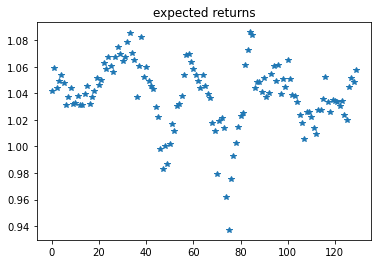

130


In [40]:
plt.plot(expected_returns,'*')
plt.title('expected returns')
plt.show()
print(len(expected_returns))

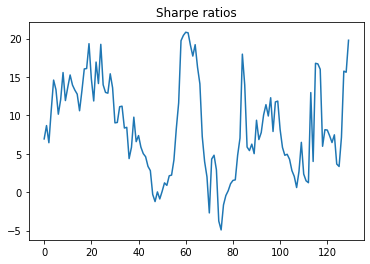

In [105]:
plt.plot(Sharpe_ratio)
plt.title('Sharpe ratios')
plt.show()

# Indicators / results
 Money KPI investment DUBAI

In [ ]:
#print(stocks2.mean(axis=0))
Sharpe=np.dot(w,stocks2.mean(axis=0))/VAR(w,stocks2)    # Sharpe ratio with the risk free rate = 0
print(Sharpe)
print(VAR(w,stocks2))
print(np.dot(w,stocks2.mean(axis=0)))